In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
# Install Java, Spark, and Findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

from pyspark import SparkFiles
url="https://qos-bucket.s3.us-east-2.amazonaws.com/credit_default.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("credit_default.csv"), sep=",", header=True, inferSchema=True)

df = df.select("*").toPandas()


df = df.dropna()
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [0]:
#testing with all possible features
X = df.drop(['default payment next month', 'ID'], axis=1)
y = df["default payment next month"]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=1000, 
                            random_state=1,
                            n_estimators=100,
                            verbose=False)
rf = rf.fit(X_train, y_train)
print(f'rf test score: {rf.score(X_test, y_test)}')

rf test score: 0.8149333333333333


In [5]:
from sklearn.metrics import confusion_matrix
predictions = rf.predict(X_test)
confusion_matrix = confusion_matrix(y_test, predictions)
confusion_matrix

array([[5523,  350],
       [1038,  589]])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


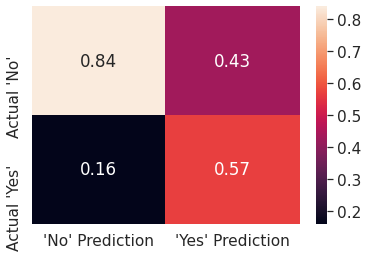

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt
#no = 6461   yes=1039  yes=
array = [[.839, .433],
         [.160, .567]]
df_cm = pd.DataFrame(array, columns=["'No' Prediction", "'Yes' Prediction"], index=["Actual 'No'", "Actual 'Yes'"])
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, )
plt.show()

In [7]:
df_cm

,'No' Prediction,'Yes' Prediction
Actual 'No',0.839,0.433
Actual 'Yes',0.160,0.567


In [0]:
#scaling data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train.values.reshape(-1, 1))
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [9]:
#testing scaled data
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
print(f'rf test score: {rf.score(X_test_scaled, y_test)}')

rf test score: 0.8144


In [10]:
#determine feature importance
feature_names = X.columns
sorted(zip(rf.feature_importances_, feature_names), reverse=True)

[(0.10396314571622745, 'PAY_0'),
 (0.06642052036050027, 'AGE'),
 (0.05954804394551006, 'BILL_AMT1'),
 (0.059419634516136764, 'LIMIT_BAL'),
 (0.05436182055123426, 'BILL_AMT2'),
 (0.051268043899682585, 'BILL_AMT3'),
 (0.05059158032772248, 'BILL_AMT6'),
 (0.05000999660610453, 'PAY_AMT1'),
 (0.04969516045106695, 'BILL_AMT5'),
 (0.049554410439022874, 'BILL_AMT4'),
 (0.04738951794090227, 'PAY_AMT2'),
 (0.04561340965948688, 'PAY_AMT3'),
 (0.04560563046526939, 'PAY_AMT6'),
 (0.043152966416929804, 'PAY_AMT5'),
 (0.042857823421929335, 'PAY_AMT4'),
 (0.04282378883546482, 'PAY_2'),
 (0.030925324130348753, 'PAY_3'),
 (0.02078359653381606, 'EDUCATION'),
 (0.020754296525250654, 'PAY_4'),
 (0.020055808209480278, 'PAY_6'),
 (0.01952988038399772, 'PAY_5'),
 (0.013752942320097501, 'MARRIAGE'),
 (0.011922658343818338, 'SEX')]

In [11]:
importance_df = pd.DataFrame({
    "feature names": feature_names,
    "importance": rf.feature_importances_
})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df


,feature names,importance
5,PAY_0,0.103963
4,AGE,0.066421
11,BILL_AMT1,0.059548
0,LIMIT_BAL,0.059420
12,BILL_AMT2,0.054362
13,BILL_AMT3,0.051268
16,BILL_AMT6,0.050592
17,PAY_AMT1,0.050010
15,BILL_AMT5,0.049695
14,BILL_AMT4,0.049554


Text(0.5, 1.0, 'Feature Importance')

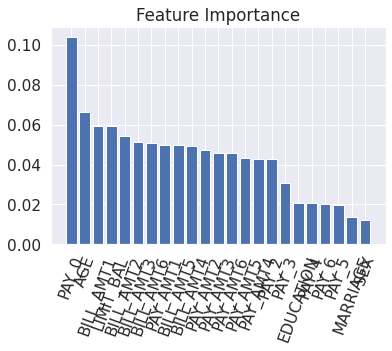

In [12]:
#plotting feature importance
import matplotlib.pyplot as plt

plt.bar(importance_df['feature names'], importance_df['importance'])
plt.xticks(rotation=70)
plt.title('Feature Importance')

In [13]:
#testing extreme random forest and cross validation 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
ert = ExtraTreesClassifier(n_estimators=200,
                           max_depth=None, 
                           min_samples_split=2, 
                           random_state=0)
scores = cross_val_score(erf, X, y, cv=5)
scores.mean()


0.8124666666666668

In [14]:
erf = erf.fit(X_train_scaled, y_train)
print(f'erf test score: {erf.score(X_test_scaled, y_test)}')

erf test score: 0.8109333333333333


In [0]:
scores_rf = cross_val_score(rf, X, y, cv=5)

In [16]:
scores_rf.mean()

0.8154666666666668